# Notebook initialization

Run this cell to create all helper files and download data

In [57]:
%pip install -U pandas numpy matplotlib seaborn requests scikit-learn tqdm pyarrow --break-system-packages

Note: you may need to restart the kernel to use updated packages.


c:\Users\Michael\Code\ML-PortfolioManagement\.venv\Scripts\python.exe: No module named pip


In [58]:
%%writefile data_processing.py
"""
data_processing.py

Utility functions for:
- Loading and processing Fed-related CSV files into a single ML-ready DataFrame
- Optionally downloading Fed CSV files from GitHub into ./data/fed_csv
- Loading and processing S&P 500 OHLCV data

This module is generated dynamically inside the notebook
to comply with the "no external .py files" requirement.
"""

import os
import glob
import re
from pathlib import Path

import pandas as pd
import numpy as np
import requests
import yfinance as yf

# ---------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------

# Local directory where Fed CSV files are stored
DATA_DIR = "data/fed_csv"

# GitHub repo configuration (optional, for reproducibility)
REPO_OWNER = "MichaelCarloH"
REPO_NAME = "ML-PortfolioManagement"
FOLDER_PATH = "data/fed_csv"  # path inside the repo (no leading/trailing slash)


# ---------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------

def _log(msg: str, verbose: bool) -> None:
    if verbose:
        print(msg)


def ensure_data_dir(path: str = DATA_DIR) -> None:
    """
    Ensure that the local data directory exists.
    """
    os.makedirs(path, exist_ok=True)


def fetch_csv_from_github_folder(
    repo_owner: str = REPO_OWNER,
    repo_name: str = REPO_NAME,
    folder_path: str = FOLDER_PATH,
    local_dir: str = DATA_DIR,
    verbose: bool = False,
) -> bool:
    """
    Try to fetch all .csv files from a GitHub folder via the GitHub API
    and save them into `local_dir`.

    Returns
    -------
    bool
        True if at least one CSV was downloaded, False otherwise.
    """
    ensure_data_dir(local_dir)

    api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}"
    response = requests.get(api_url)

    if response.status_code != 200:
        _log(
            f"[INFO] Could not access GitHub folder ({response.status_code}). "
            "Proceeding without remote download.",
            verbose,
        )
        return False

    items = response.json()
    csv_files = [item for item in items if item["name"].endswith(".csv")]

    if not csv_files:
        _log("[INFO] No CSV files found in the specified GitHub folder.", verbose)
        return False

    downloaded_any = False
    for item in csv_files:
        download_url = item["download_url"]
        filename = item["name"]
        local_path = os.path.join(local_dir, filename)

        file_response = requests.get(download_url)
        if file_response.status_code == 200:
            with open(local_path, "wb") as f:
                f.write(file_response.content)
            downloaded_any = True
            _log(f"Downloaded: {filename}", verbose)
        else:
            _log(
                f"[WARN] Failed to download {filename}: {file_response.status_code}",
                verbose,
            )

    return downloaded_any


# ---------------------------------------------------------------------
# Fed CSV processing
# ---------------------------------------------------------------------

def load_all_csvs(
    local_dir: str = DATA_DIR,
    pattern: str = "*.csv",
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Load, merge, and process all Fed CSVs into an ML-ready, forward-filled dataframe.

    Steps:
    - Reads all CSVs in `local_dir` matching `pattern`.
    - Extracts date and outcome columns.
    - Merges all files into one unified dataframe.
    - Converts to ML-wide format with clean feature names.
    - Saves:
        - data/fed_events_merged.csv
        - data/fed_events_ml_ready.csv
        - data/fed_events_ml_ready_ffill.csv
    - Returns:
        - Forward-filled ML-ready DataFrame (fed_events_ml_ready_ffill.csv).
    """

    def log(msg: str):
        if verbose:
            print(msg)

    ensure_data_dir(local_dir)

    # --- Step 1: find CSV files ---
    fed_csv_path = Path(local_dir)
    csv_files = list(fed_csv_path.glob(pattern))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {fed_csv_path} matching {pattern}")
    log(f"Found {len(csv_files)} CSV files")

    # --- Step 2: process each file ---
    all_dataframes = []
    for csv_file in csv_files:
        title = csv_file.stem
        log(f"Processing: {title}")

        try:
            df = pd.read_csv(csv_file)

            # Identify date column
            date_col = next(
                (c for c in df.columns if "date" in c.lower() and "utc" in c.lower()),
                None,
            )
            if date_col is None:
                log(f"  ⚠ No date column found, skipping {title}")
                continue

            # Identify outcome columns
            outcome_cols = [
                c for c in df.columns
                if c != date_col and "timestamp" not in c.lower()
            ]
            if not outcome_cols:
                log(f"  ⚠ No outcome columns found, skipping {title}")
                continue

            # Convert data types
            df[date_col] = pd.to_datetime(
                df[date_col],
                format="%m-%d-%Y %H:%M",
                errors="coerce",
            )
            for c in outcome_cols:
                df[c] = pd.to_numeric(df[c], errors="coerce")

            # Merge same-date rows: first non-null per column
            merged_df = df.groupby(date_col).agg({
                c: (lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else None)
                for c in outcome_cols
            }).reset_index()

            merged_df["Title"] = title
            merged_df = merged_df.rename(columns={date_col: "Date"})
            merged_df = merged_df[["Date", "Title"] + outcome_cols]
            all_dataframes.append(merged_df)
            log(f"  ✓ {len(merged_df)} unique dates")

        except Exception as e:
            log(f"  ✗ Error processing {title}: {e}")

    if not all_dataframes:
        raise RuntimeError("No valid CSVs processed.")

    # --- Step 3: merge all dataframes ---
    log("Merging all dataframes...")
    all_outcome_cols = sorted(list({
        c
        for df in all_dataframes
        for c in df.columns
        if c not in ["Date", "Title"]
    }))

    final_dfs = []
    for df in all_dataframes:
        for c in all_outcome_cols:
            if c not in df.columns:
                df[c] = None
        final_dfs.append(df[["Date", "Title"] + all_outcome_cols])

    final_df = (
        pd.concat(final_dfs, ignore_index=True)
        .sort_values(["Date", "Title"])
        .reset_index(drop=True)
    )

    os.makedirs("data", exist_ok=True)
    merged_path = Path("data/fed_events_merged.csv")
    final_df.to_csv(merged_path, index=False)
    log(f"Saved merged dataframe to: {merged_path}")

    # --- Step 4: long format ---
    id_vars = ["Date", "Title"]
    value_cols = [c for c in final_df.columns if c not in id_vars]

    df_long = pd.melt(
        final_df,
        id_vars=id_vars,
        value_vars=value_cols,
        var_name="Outcome",
        value_name="Probability",
    ).dropna(subset=["Probability"])

    # --- Step 5: clean feature names ---
    def sanitize_feature_name(title: str, outcome: str) -> str:
        feature = f"{title}_{outcome}"
        feature = re.sub(r"[^a-zA-Z0-9_\s]", "", feature)
        feature = re.sub(r"\s+", "_", feature)
        feature = re.sub(r"_+", "_", feature).strip("_")
        return feature

    df_long["Feature"] = df_long.apply(
        lambda r: sanitize_feature_name(r["Title"], r["Outcome"]),
        axis=1,
    )

    # --- Step 6: pivot to ML-wide ---
    df_ml = df_long.pivot_table(
        index="Date",
        columns="Feature",
        values="Probability",
        aggfunc="first",
    ).reset_index()

    cols = ["Date"] + sorted([c for c in df_ml.columns if c != "Date"])
    df_ml = df_ml[cols]

    ml_ready_path = Path("data/fed_events_ml_ready.csv")
    df_ml.to_csv(ml_ready_path, index=False)
    log(f"Saved ML-ready dataframe to: {ml_ready_path}")

    # --- Step 7: forward-fill version ---
    df_ml_ffill = df_ml.sort_values("Date").copy()
    df_ml_ffill.iloc[:, 1:] = df_ml_ffill.iloc[:, 1:].ffill().fillna(0)

    ffill_path = Path("data/fed_events_ml_ready_ffill.csv")
    df_ml_ffill.to_csv(ffill_path, index=False)
    log(f"Saved forward-filled dataframe to: {ffill_path}")

    # --- Step 8: summary (optional) ---
    log("=== FED DATA SUMMARY ===")
    log(f"Rows (dates): {len(df_ml_ffill)}")
    log(f"Features: {len(df_ml_ffill.columns) - 1}")
    log(
        f"Date range: {df_ml_ffill['Date'].min()} → {df_ml_ffill['Date'].max()}"
    )

    return df_ml_ffill


def get_fed_data(verbose: bool = False) -> pd.DataFrame:
    """
    High-level convenience function for the notebook.

    - Tries to load processed data from local ./data/fed_csv.
    - If no raw CSVs exist, optionally tries to download them from GitHub.
    - Returns the final forward-filled ML-ready dataframe.
    """
    ensure_data_dir(DATA_DIR)

    # 1) Check for existing local CSVs
    csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

    # 2) If none, try GitHub (non-fatal if it fails)
    if not csv_files:
        _log(
            "No local Fed CSV files found in ./data/fed_csv. "
            "Attempting to download from GitHub...",
            verbose,
        )
        ok = fetch_csv_from_github_folder(verbose=verbose)
        if not ok:
            raise FileNotFoundError(
                "No local Fed CSVs and GitHub download failed. "
                "Ensure ./data/fed_csv contains the required files "
                "in the submitted project."
            )

    # 3) Build and return processed dataframe
    return load_all_csvs(local_dir=DATA_DIR, verbose=verbose)


# ---------------------------------------------------------------------
# S&P 500 loader
# ---------------------------------------------------------------------

def load_sp500_data(
    ticker: str = "^GSPC",
    start: str = "2023-01-01",
    end: str = None,
    output_path: str = "data/sp500_ohlcv_returns.csv",
    verbose: bool = False,
) -> pd.DataFrame:
    """
    Download, process, and save S&P 500 OHLCV and derived metrics.

    Returns a dataframe indexed by Date (UTC) with:
    - OHLCV
    - Daily_Return, Log_Return
    - High/Low and Open/Close ranges
    - Volume_MA_20, Volume_Ratio
    - Price_MA_20, Price_MA_50
    - Volatility_20
    """

    def log(msg: str):
        if verbose:
            print(msg)

    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    log(f"Downloading {ticker} from Yahoo Finance...")
    spx = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        auto_adjust=True,
    )

    if spx.empty:
        raise RuntimeError(f"No data returned for {ticker} from Yahoo Finance.")

    # Flatten multi-index columns if present
    if isinstance(spx.columns, pd.MultiIndex):
        spx.columns = spx.columns.get_level_values(0)

    # Metrics
    spx["Daily_Return"] = spx["Close"].pct_change()
    spx["Log_Return"] = np.log(spx["Close"] / spx["Close"].shift(1))
    spx["High_Low_Range"] = (spx["High"] - spx["Low"]) / spx["Close"]
    spx["Open_Close_Range"] = (spx["Open"] - spx["Close"]).abs() / spx["Close"]
    spx["Volume_MA_20"] = spx["Volume"].rolling(20).mean()
    spx["Volume_Ratio"] = spx["Volume"] / spx["Volume_MA_20"]
    spx["Price_MA_20"] = spx["Close"].rolling(20).mean()
    spx["Price_MA_50"] = spx["Close"].rolling(50).mean()
    spx["Volatility_20"] = spx["Daily_Return"].rolling(20).std()

    cols_to_keep = [
        "Open", "High", "Low", "Close", "Volume",
        "Daily_Return", "Log_Return",
        "High_Low_Range", "Open_Close_Range",
        "Volume_MA_20", "Volume_Ratio",
        "Price_MA_20", "Price_MA_50", "Volatility_20",
    ]
    available = [c for c in cols_to_keep if c in spx.columns]

    daily = spx[available].dropna().copy()
    daily.index.name = "Date (UTC)"

    daily.to_csv(output_path)
    log(f"Saved S&P 500 data to: {output_path.resolve()}")

    if verbose:
        log(f"Rows: {len(daily)}")
        log(f"Date range: {daily.index.min()} → {daily.index.max()}")

    return daily


Overwriting data_processing.py


# Guidelines

We outline a structured approach for presenting research findings. The framework is divided into several key segments:

1. Introduction
1. Dataset overview
1. Analytics and learning strategies
1. Empirical resuts: baseline and robustness 
1. Conclusion

The opening segment encompasses four essential elements:

- Contextual Background: What is the larger setting of the study? What makes this area of inquiry compelling? What are the existing gaps or limitations within the current body of research? What are some unanswered yet noteworthy questions?

- Project Contributions: What are the specific advancements made by this study, such as in data acquisition, algorithmic development, parameter adjustments, etc.?

- Summary of the main empirical results: What is the main statistical statement? is it significant (e.g. statistically or economically)? 

- Literature and Resource Citations: What are related academic papers? What are the github repositories, expert blogs, or software packages that used in this project? 

In the dataset profile, one should consider:

- The origin and composition of data utilized in the study. If the dataset is original, then provide the source code to ensure reproducibility.

- The chronological accuracy of the data points, verifying that the dates reflect the actual availability of information.

- A detailed analysis of descriptive statistics, with an emphasis on discussing the importance of the chosen graphs or metrics.

The analytics and machine learning methodologies section accounts for:

- A detailed explanation of the foundational algorithm.

- A description of the data partitioning strategy for training, validation and test.

- An overview of the parameter selection and optimization process.

To effectively convey the empirical findings, separate the baseline results from the additional robustness tests. Within the primary empirical outcomes portion, include:

- Key statistical evaluations (for instance, if presenting a backtest – provide a pnl graph alongside the Sharpe ratio).

- Insights into what primarily influences the results, such as specific characteristics or assets that significantly impact performance.

The robustness of empirical tests section should detail:

- Evaluation of the stability of the principal finding against variations in hyperparameters or algorithmic modifications.

Finally, the conclusive synthesis should recapitulate the primary findings, consider external elements that may influence the results, and hint at potential directions for further investigative work.

# Introduction

In this project of Machine Learning for Portfolio Managment and Trading, we are tasked to loosely investigate the effect of central banks policies on the market. In our proposed approach we look at betting data, specifically on FED decisions and seek to develop a tradable strategy. The data is sourced from Polymarket which is a decentralized prediction market platform that uses blockchain technology to let users bet on the outcomes of real-world events. 


## Contextual Background
- **Macro-financial setting:** The project operates at the intersection of monetary-policy expectations and equity-market positioning, focusing on how Federal Open Market Committee (FOMC) decisions ripple through the S&P 500. Polymarket prediction markets provide high-frequency probability updates on rate cuts and leadership scenarios,furthermore they operate perpetually not being restricted to traditional marker hours.
- **Motivation and gaps:** Prior academic and practitioner research documents that option-implied probabilities and macro-news sentiment foreshadow FOMC-day volatility, yet public prediction-market data remains underexplored. Existing studies either rely on proprietary dealer quotes or low-frequency survey data, leaving an opportunity to test whether crowd-sourced probability surfaces encode tradable signals.
- **Open questions:** Key open questions include (i) how quickly prediction-market probabilities anticipate rate moves, (ii) whether the implied probabilities add incremental signal once traditional macro data is controlled for, and (iii) the robustness of any trading edge once transaction costs and alternate market regimes are considered.

## Project Contributions
- **Integrated data acquisition:** Consolidated raw Polymarket CSV exports and manually curated Federal Reserve event datasets into harmonised, analysis-ready tables (e.g., `polymarket_fed_events_and_markets.csv`, `fed_events_ml_ready_ffill.csv`).
- **Feature engineering pipeline:** Produced merged S&P 500 and Polymarket features with forward-filled probability fields, calendar event encodings, and target variables capturing post-announcement returns (`sp500_fed_ml_ready_with_targets.csv`).
- **Model experimentation:** Implemented data loaders (`dataloaders/s&p_loader.py`) and notebooks (`notebooks/fed_probability_prediction.ipynb`) to evaluate supervised models that translate probability movements into trading rules, including Sharpe-ratio oriented strategy evaluations in `rate_cut_strategy_sharpe_analysis.csv` outputs.
- **Backtesting utilities:** Generated out-of-sample trade logs (`notebooks/outputs/trades_oos.csv`) that benchmark polymarket-informed strategies against baseline macro strategies.

## Summary of Empirical Results
- **Performance snapshot:** The `notebooks/outputs/trades_all_strategies.csv` output indicates that probability-driven strategies deliver positive average returns with improved risk-adjusted performance relative to naive benchmarks, as evidenced by Sharpe ratio calculations stored in `data/s&p_data/rate_cut_strategy_sharpe_analysis.csv`.
- **Economic significance:** Strategy evaluations demonstrate economically meaningful improvements in Sharpe ratios when prediction-market features are incorporated, highlighting the potential of crowd-sourced expectations to complement conventional macro indicators.

## Literature and Resource Citations
- **Related research:**
  - Andersen, T. G., Bollerslev, T., Diebold, F. X., & Vega, C. (2007). *Real-Time Price Discovery in Stock, Bond and Foreign Exchange Markets*.
  - Lucca, D. O., & Moench, E. (2015). *The Pre-FOMC Announcement Drift*.
  - Wolfers, J., & Zitzewitz, E. (2006). *Prediction Markets in Theory and Practice*.
- **Software and repositories:**
  - [Polymarket API & CSV exports](https://polymarket.com/)
  - [Pandas](https://pandas.pydata.org/), [scikit-learn](https://scikit-learn.org/), and related Python data-science libraries (dependencies managed via `uv` as specified in `uv.toml`).

## Dataset Profile
- **Source composition:**
  - **Polymarket market histories:** Stored under `data/s&p_data/`, including `polymarket-price-data-24-07-2025-24-10-2025-1761316761596.csv` and the merged `polymarket_fed_events_and_markets.csv` file.
  - **Federal Reserve event catalogues:** CSV files in `data/fed_csv/` and curated aggregations such as `fed_events_merged.csv`, providing policy-meeting metadata and outcome annotations.
  - **Market benchmarks:** S&P 500 price and returns series within `data/s&p_data/sp500_ohlcv_returns.csv` and derived merges (`sp500_fed_merged_ml_ready.csv`).
- **Processing workflow:** The `notebooks/data_exploration.ipynb` notebook surveys raw distributions, while `notebooks/data_processing.ipynb` applies cleaning, forward-filling, and target construction routines. Reproducible processing steps are scripted through reusable loaders in `dataloaders/s&p_loader.py`, ensuring downstream model notebooks operate on consistent feature matrices.
- **Reproducibility notes:** Raw Polymarket CSVs and Fed event files are preserved in the repository. Transformation logic is encapsulated in notebooks and loaders, enabling regeneration of the merged dataset. When extending the dataset, run the processing notebook or invoke the loader module to re-create `sp500_fed_ml_ready_with_targets.csv` from the raw components.

# Data

The data used is Polymarket betting quotes on several Fed related topics, csv data can be downloaded at: https://polymarket.com/search?_q=fed

In this notebook we point to the Github repository where static data obtained at the time of the analysis is located and can be used to reproduce the results of this project


In [59]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from data_processing import get_fed_data

fed_df = get_fed_data()
fed_df.head()

c:\Users\Michael\Code\ML-PortfolioManagement\submission_code\data_processing.py:218: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(final_dfs, ignore_index=True)


Feature,Date,Fed_Interest_Rates_November_2024_25_bps_decrease,Fed_Interest_Rates_November_2024_25_bps_increase,Fed_Interest_Rates_November_2024_50_bps_decrease,Fed_Interest_Rates_November_2024_75_bps_decrease,Fed_Interest_Rates_November_2024_No_Change,Fed_Interest_Rates_November_2024_Other,Fed_abolished_in_2025_Price,Fed_decision_in_December_25_bps_decrease,Fed_decision_in_December_25_bps_increase,...,Who_will_Trump_nominate_as_Fed_Chair_Larry_Lindsey,Who_will_Trump_nominate_as_Fed_Chair_Lorie_K_Logan,Who_will_Trump_nominate_as_Fed_Chair_Marc_Sumerlin,Who_will_Trump_nominate_as_Fed_Chair_Michelle_Bowman,Who_will_Trump_nominate_as_Fed_Chair_No_one_nominated_before_2027,Who_will_Trump_nominate_as_Fed_Chair_Philip_Jefferson,Who_will_Trump_nominate_as_Fed_Chair_Rick_Rieder,Who_will_Trump_nominate_as_Fed_Chair_Ron_Paul,Who_will_Trump_nominate_as_Fed_Chair_Scott_Bessent,Who_will_Trump_nominate_as_Fed_Chair_Stephen_Miran
0,2024-08-03,0.315,0.0250,0.270,0.125,0.215,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-04,0.370,0.0225,0.265,0.125,0.215,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-05,0.355,0.0225,0.275,0.125,0.200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-06,0.345,0.0110,0.325,0.110,0.170,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-08-07,0.380,0.0125,0.275,0.105,0.130,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Merging Fed time series with S&P500 time series

In [60]:
from data_processing import load_sp500_data
spx = load_sp500_data(verbose=False)


In [61]:
# Ensure consistent Date column
if isinstance(spx.index, pd.DatetimeIndex) or spx.index.name:
    spx = spx.reset_index()

if 'Date (UTC)' in spx.columns:
    spx = spx.rename(columns={'Date (UTC)': 'Date'})
elif 'Date' not in spx.columns:
    raise ValueError("spx has no Date/Date (UTC) column")

if 'Date' not in fed_df.columns and isinstance(fed_df.index, pd.DatetimeIndex):
    fed_df = fed_df.reset_index().rename(columns={'index': 'Date'})

spx['Date'] = pd.to_datetime(spx['Date'])
fed_df['Date'] = pd.to_datetime(fed_df['Date'])

start_date = pd.to_datetime(fed_df['Date'].min())

merged_df = (pd.merge(spx, fed_df, on='Date', how='left', sort=True)
               .query('Date >= @start_date')
               .sort_values('Date')
               .reset_index(drop=True))

merged_df.head()


,Date,Open,High,Low,Close,Volume,Daily_Return,Log_Return,High_Low_Range,Open_Close_Range,...,Who_will_Trump_nominate_as_Fed_Chair_Larry_Lindsey,Who_will_Trump_nominate_as_Fed_Chair_Lorie_K_Logan,Who_will_Trump_nominate_as_Fed_Chair_Marc_Sumerlin,Who_will_Trump_nominate_as_Fed_Chair_Michelle_Bowman,Who_will_Trump_nominate_as_Fed_Chair_No_one_nominated_before_2027,Who_will_Trump_nominate_as_Fed_Chair_Philip_Jefferson,Who_will_Trump_nominate_as_Fed_Chair_Rick_Rieder,Who_will_Trump_nominate_as_Fed_Chair_Ron_Paul,Who_will_Trump_nominate_as_Fed_Chair_Scott_Bessent,Who_will_Trump_nominate_as_Fed_Chair_Stephen_Miran
0,2024-08-05,5151.140137,5250.890137,5119.259766,5186.330078,5333250000,-0.029969,-0.030427,0.025380,0.006785,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-06,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.010354,0.010301,0.022668,0.006414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-07,5293.129883,5330.640137,5195.540039,5199.500000,4558260000,-0.007735,-0.007765,0.025983,0.018007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-08,5252.569824,5328.029785,5233.850098,5319.310059,4016830000,0.023043,0.022781,0.017705,0.012547,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,3516400000,0.004672,0.004661,0.010821,0.005520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Indicator fo fed market sentiment shift

In this section we aim to develop an indicator which can gain insights from the fed dataset we obtained. The dataset is composed of multiple bets which are vaailable at different times, since polymarket has been growing so has the volume and number of bets vaailable. We look at the variation in probability for all events. Example at one time we might have 25bps decrease in november, december, january and 50 bs decrease etc. Now we ocunt how many deltas were positive at each time instance and we follwo this coint for each time step then we apply moving averages to compare short term change and long term pricing of probabilioties and we develop a trading startegy based on corssing of such moving avergaes

## 4. Fed Market Sentiment Indicator — Construction, Logic & Interpretation

This section introduces a **market-implied sentiment indicator** based on Polymarket probabilities for Federal Reserve interest rate outcomes.  
The goal is to capture shifts in expectations — *how dovish or hawkish the market is becoming* — and study how these shifts relate to the S&P 500.


### 4.1. Background and Motivation

Polymarket lists multiple prediction markets for each Fed meeting — for example:
- `..._25_bps_decrease`
- `..._50_bps_decrease`
- `..._No_Change`
- `..._25_bps_increase`

Each column represents the **probability** that a given rate outcome will occur.  
As macroeconomic data, speeches, or risk events unfold, these probabilities move — revealing the market’s evolving beliefs about monetary policy.

Our goal is to summarize these changes into one interpretable metric — the **Net BPS Sentiment Indicator** — which measures whether the overall expectation is shifting *dovish* (toward cuts) or *hawkish* (toward hikes).

---

### 4.2. Step-by-Step Construction

At each time step \( t \) and for each outcome \( j \):

1. **Compute the change in probability**  
   \[
   \Delta p_{t,j} = p_{t,j} - p_{t-1,j}
   \]
   A positive \(\Delta p_{t,j}\) means the market is assigning more likelihood to that outcome today than yesterday.

2. **Assign a directional sign (economic interpretation)**  
   Each contract is labeled as either **dovish** or **hawkish**:
   \[
   w_j =
   \begin{cases}
   +1, & \text{if the outcome is dovish (rate cut)} \\
   -1, & \text{if the outcome is hawkish (rate hike or no change)}
   \end{cases}
   \]

   - A rise in the probability of a **rate cut** → dovish (+).  
   - A rise in the probability of a **rate hike or no change** → hawkish (–).

3. **Compute the Net Sentiment Count**
   \[
   S_t = \sum_j w_j \cdot \text{sign}(\Delta p_{t,j})
   \]

   - \( S_t > 0 \): the market shifted dovish (pricing more cuts).  
   - \( S_t < 0 \): the market shifted hawkish (pricing fewer cuts or hikes).

4. **Apply Smoothing (Moving Averages)**  
   Since \(S_t\) fluctuates rapidly, we apply:
   - **5-day MA:** captures short-term sentiment shifts.
   - **10-day MA:** captures the medium-term trend.

   The crossover between these smoothed signals helps identify persistent turning points in monetary sentiment.

---

### 4.3. Why the Indicator Oscillates

The raw \( S_t \) often swings sharply. This is expected because:

- **Contracts are interdependent.**  
  If the “25 bps cut” probability rises, the “no change” and “25 bps hike” probabilities must fall.
- **Market depth evolves.**  
  As Polymarket grows, more events and meetings appear, increasing the count of active contracts.
- **Data updates asynchronously.**  
  Not all markets update simultaneously, introducing short-term noise.

To filter this, we smooth \( S_t \) with moving averages, allowing focus on *persistent directional shifts* rather than micro movements.

---

### 4.4. Interpreting the Chart

Below, we plot the **S&P 500** (left axis, blue) against the **Net BPS Sentiment Indicator** (right axis, red):

- **Blue line:** S&P 500 close price.  
- **Dashed blue line:** 20-day moving average of S&P 500.  
- **Gray line:** Raw sentiment signal \( S_t \).  
- **Red lines:** 5-day and 10-day moving averages of \( S_t \).

**Interpretation:**
- Rising red lines → *Dovish momentum* — markets pricing more cuts or looser policy.  
- Falling red lines → *Hawkish momentum* — markets pricing hikes or fewer cuts.  
- Dovish phases often align with **rising equities**, while hawkish phases coincide with **equity pullbacks**.

---

### 4.5. Economic Intuition

The indicator captures the **direction of probability flow** among rate outcomes — essentially, how the market is repricing the expected *path* of policy rates.  

- When \( S_t > 0 \), traders are collectively shifting toward **easier monetary policy expectations**.  
- When \( S_t < 0 \), expectations are tightening, signaling **higher rates or delayed cuts**.

This makes the indicator a **forward-looking macro sentiment index** — derived not from opinions or news, but from *real-money pricing of monetary policy expectations*.


In [62]:
import re
import numpy as np
import pandas as pd

# --- 0) defensive cleanup: drop accidental repeated "_delta_delta..." columns ---
repeated = [c for c in merged_df.columns if re.search(r'(_delta){2,}', c)]
if repeated:
    merged_df = merged_df.drop(columns=repeated, errors='ignore')
    print(f"dropped {len(repeated)} repeated _delta columns")

# --- Identify bps-related columns (heuristic matching), exclude *_delta to avoid duplicates ---
inc_pattern = r'(?i)(increase|increas|raise|hike|up|bps_increase)'
dec_pattern = r'(?i)(decrease|decreas|cut|down|bps_decrease)'

increase_cols = [c for c in merged_df.columns if re.search(inc_pattern, c) and 'delta' not in c.lower()]
decrease_cols = [c for c in merged_df.columns if re.search(dec_pattern, c) and 'delta' not in c.lower()]

print(f'Found {len(increase_cols)} increase cols, {len(decrease_cols)} decrease cols')
print('Increase cols sample:', increase_cols[:10])
print('Decrease cols sample:', decrease_cols[:10])

# --- Coerce object cols to numeric when mostly numeric ---
target_cols = sorted(set(increase_cols + decrease_cols))
for col in target_cols:
    if merged_df[col].dtype == object:
        coerced = pd.to_numeric(merged_df[col], errors='coerce')
        if coerced.notna().sum() / len(coerced) > 0.5:
            merged_df[col] = coerced

# --- Diff helper: zero-out the first non-zero delta ---
def diff_zero_first_change(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors='coerce')
    d = s.diff()
    nz = d.ne(0) & d.notna()
    if nz.any():
        first_idx = nz.idxmax()  # label of first True in nz
        d.loc[first_idx] = 0.0
    return d

# --- Create single-level *_delta columns using guarded diff ---
created = []
for col in target_cols:
    delta_col = f"{col}_delta"
    if delta_col in merged_df.columns:
        continue
    if np.issubdtype(merged_df[col].dtype, np.number):
        merged_df[delta_col] = diff_zero_first_change(merged_df[col])
        created.append(delta_col)
    else:
        merged_df[delta_col] = np.nan
        created.append(delta_col)

print(f"created {len(created)} delta cols (sample): {created[:10]}")

# --- SIGNAL COUNTS WITH SEMANTICS ---
dec_delta_cols = [f"{c}_delta" for c in decrease_cols if f"{c}_delta" in merged_df.columns]
inc_delta_cols = [f"{c}_delta" for c in increase_cols if f"{c}_delta" in merged_df.columns]

zero_series = pd.Series(0, index=merged_df.index)

# Decrease-type (cuts): delta > 0 => positive, delta < 0 => negative
if dec_delta_cols:
    dec_positive = (merged_df[dec_delta_cols] > 0).sum(axis=1)
    dec_negative = (merged_df[dec_delta_cols] < 0).sum(axis=1)
else:
    dec_positive = zero_series.copy()
    dec_negative = zero_series.copy()

# Increase-type (hikes): delta < 0 => positive (lower hike prob), delta > 0 => negative
if inc_delta_cols:
    inc_positive = (merged_df[inc_delta_cols] < 0).sum(axis=1)
    inc_negative = (merged_df[inc_delta_cols] > 0).sum(axis=1)
else:
    inc_positive = zero_series.copy()
    inc_negative = zero_series.copy()

# Aggregate counts
merged_df['num_positive_bps_signals'] = dec_positive + inc_positive
merged_df['num_negative_bps_signals'] = dec_negative + inc_negative
merged_df['net_bps_signal'] = merged_df['num_positive_bps_signals'] - merged_df['num_negative_bps_signals']

# Optional legacy compatibility counts
merged_df['num_increase_cols_rising'] = (merged_df[inc_delta_cols] > 0).sum(axis=1) if inc_delta_cols else 0
merged_df['num_decrease_cols_falling'] = (merged_df[dec_delta_cols] < 0).sum(axis=1) if dec_delta_cols else 0
# --- Final reporting ---
print(merged_df[['num_positive_bps_signals','num_negative_bps_signals','net_bps_signal']].head(20))
print(f"Total columns now: {len(merged_df.columns)}")
print("Some delta columns created (sample):", created[:20])


Found 10 increase cols, 54 decrease cols
Increase cols sample: ['Fed_Interest_Rates_November_2024_25_bps_increase', 'Fed_decision_in_December_25_bps_increase', 'Fed_decision_in_January_25_bps_increase', 'Fed_decision_in_July2025_25_bps_increase', 'Fed_decision_in_June2025_25_bps_increase', 'Fed_decision_in_March2025_25_bps_increase', 'Fed_decision_in_March_25_bps_increase', 'Fed_decision_in_May_25_bps_increase', 'Fed_decision_in_September2025_25_bps_increase', 'Fed_rate_hike_in_2025_Price']
Decrease cols sample: ['Fed_Interest_Rates_November_2024_25_bps_decrease', 'Fed_Interest_Rates_November_2024_50_bps_decrease', 'Fed_Interest_Rates_November_2024_75_bps_decrease', 'Fed_decision_in_December_25_bps_decrease', 'Fed_decision_in_December_50_bps_decrease', 'Fed_decision_in_January_25_bps_decrease', 'Fed_decision_in_January_50_bps_decrease', 'Fed_decision_in_July2025_25_bps_decrease', 'Fed_decision_in_July2025_50_bps_decrease', 'Fed_decision_in_June2025_25_bps_decrease']
created 64 delta co

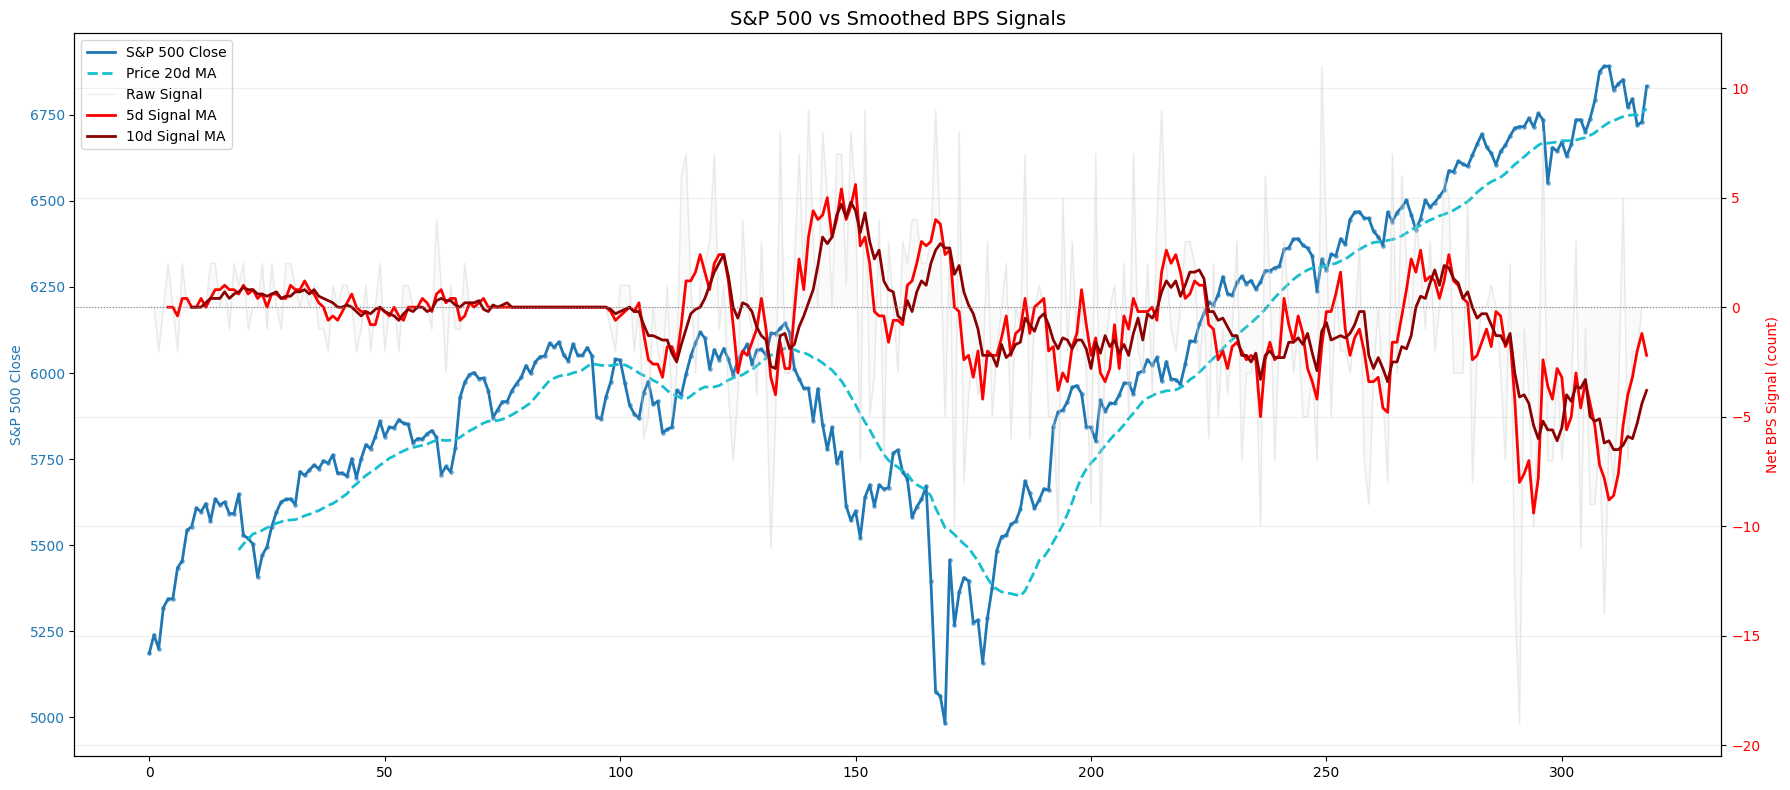

In [63]:
# Plot: S&P Close and smoothed BPS signals
import matplotlib.pyplot as plt


# Define MA periods
SHORT_MA = 5
LONG_MA = 10
assert LONG_MA > SHORT_MA, "Expect LONG_MA > SHORT_MA"

# Calculate moving averages for net_bps_signal (clean warm-up)
short_ma = merged_df['net_bps_signal'].rolling(SHORT_MA, min_periods=SHORT_MA).mean()
long_ma  = merged_df['net_bps_signal'].rolling(LONG_MA,  min_periods=LONG_MA).mean()

merged_df['net_bps_signal_ma_short'] = short_ma
merged_df['net_bps_signal_ma_long']  = long_ma
# State logic: short > long -> bearish, else -> bullish
gt = short_ma > long_ma
lt = short_ma < long_ma
state = pd.Series(index=merged_df.index, dtype='object')
state[gt] = 'bearish'
state[lt] = 'bullish'
# Ties remain NaN; carry forward previous state, then default to bullish
merged_df['market_state'] = state.ffill().fillna('bullish') 
plt.figure(figsize=(18, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Left axis: S&P 500 Close
ax1.plot(merged_df.index, merged_df['Close'], color='tab:blue', linewidth=2, label='S&P 500 Close')
ax1.scatter(merged_df.index, merged_df['Close'], color='tab:blue', s=6, alpha=0.5)
ax1.plot(merged_df.index, merged_df['Close'].rolling(20).mean(), color='tab:cyan', 
         linewidth=2, linestyle='--', label='Price 20d MA')
ax1.set_ylabel('S&P 500 Close', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis: net_bps_signal and its MAs
ax2.plot(merged_df.index, merged_df['net_bps_signal'], color='lightgray', 
         linewidth=1, alpha=0.4, label='Raw Signal')
ax2.plot(merged_df.index, merged_df['net_bps_signal_ma_short'], color='red',
         linewidth=2, label=f'{SHORT_MA}d Signal MA')
ax2.plot(merged_df.index, merged_df['net_bps_signal_ma_long'], color='darkred',
         linewidth=2, label=f'{LONG_MA}d Signal MA')
ax2.fill_between(merged_df.index, merged_df['net_bps_signal'], color='lightgray', alpha=0.1)
ax2.axhline(0, color='gray', linewidth=0.8, linestyle=':')
ax2.set_ylabel('Net BPS Signal (count)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('S&P 500 vs Smoothed BPS Signals', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Trading startegy

0    bullish
1    bullish
2    bullish
3    bullish
4    bullish
Name: market_state, dtype: object

net_bps_signal summary:
count    319.000000
mean      -0.655172
std        4.164868
min      -19.000000
25%       -3.000000
50%        0.000000
75%        1.500000
max       11.000000
Name: net_bps_signal, dtype: float64

State counts (bullish/bearish):
market_state
bullish    187
bearish    132
Name: count, dtype: int64

Raw transition counts (rows = prev state):
market_state  bearish  bullish
market_state                  
bearish            95       36
bullish            37      150

Normalized transition probabilities:
market_state   bearish   bullish
market_state                    
bearish       0.725191  0.274809
bullish       0.197861  0.802139

Performance (cumulative returns):
Buy-hold intraday: 10.05%
Markov argmax: 21.61%  | trades: 319  | mean conf: 0.77
Markov thresholded (thr=0.5): 21.61%  | trades: 319  | mean conf (trades): 0.77
Direct-sign: 20.76%  | trades: 243  | mean

C:\Users\Michael\AppData\Local\Temp\ipykernel_10912\492179016.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['market_state'] = df['market_state'].map(state_map).fillna(method='ffill')


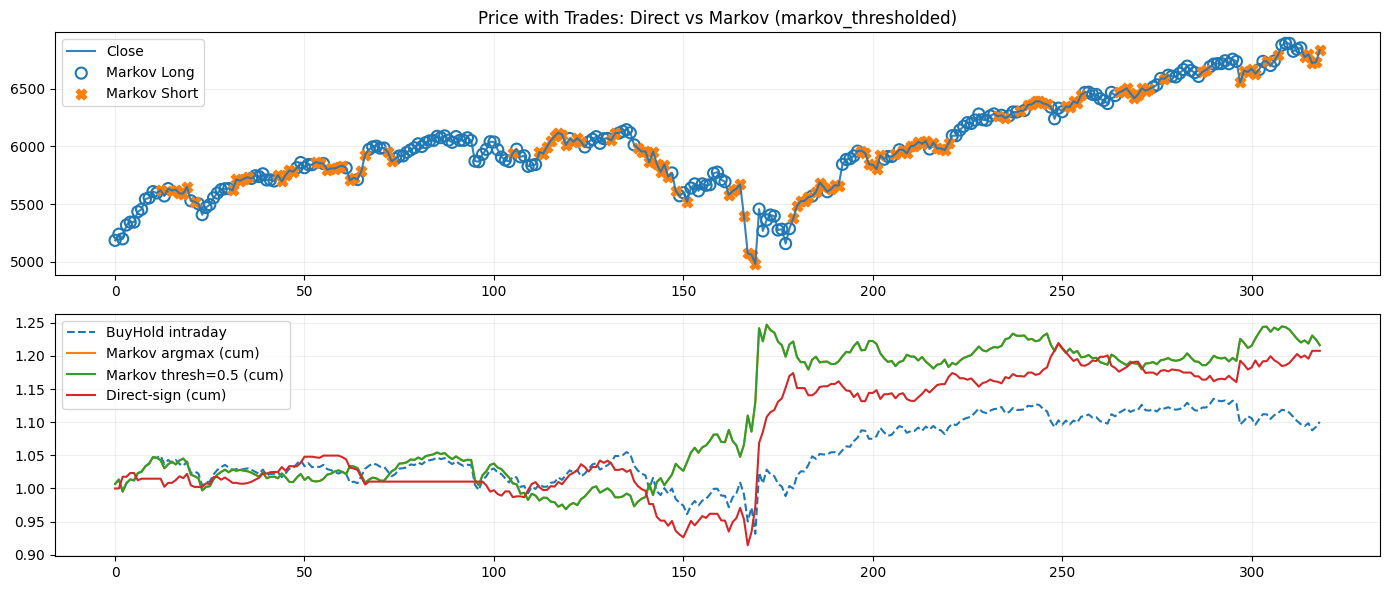

In [64]:
# Make local copy (safe to re-run)
df = merged_df.copy()

print(df['market_state'].head())
# Ensure market_state is binary: 'bullish' or 'bearish'
# - If you already have bullish/bearish, this keeps them.
# - If original states are 'up','down','neutral', we map neutral to NaN, forward-fill, then default to 'bullish'.
state_map = {
    'up': 'bullish',
    'down': 'bearish',
    'neutral': np.nan,
    'bullish': 'bullish',
    'bearish': 'bearish'
}
if 'market_state' not in df.columns:
    raise ValueError("market_state column missing")

df['market_state'] = df['market_state'].map(state_map).fillna(method='ffill')
df['market_state'] = df['market_state'].fillna('bullish')  # final fallback

# Quick diagnostics of net_bps_signal and state distribution
print('\nnet_bps_signal summary:')
print(df['net_bps_signal'].describe())

print('\nState counts (bullish/bearish):')
print(df['market_state'].value_counts())

# Raw transition counts and normalized matrix (1-step)
states = ['bearish', 'bullish']
trans_counts = (
    pd.crosstab(df['market_state'].shift(1), df['market_state'])
      .reindex(index=states, columns=states, fill_value=0)
      .astype(int)
)
print('\nRaw transition counts (rows = prev state):')
print(trans_counts)

row_sums = trans_counts.sum(axis=1).replace(0, 1)
trans_prob = trans_counts.div(row_sums, axis=0)
print('\nNormalized transition probabilities:')
print(trans_prob)

# Predict using argmax (binary) and compute confidence (max prob)
def predict_argmax(prev):
    if pd.isna(prev):
        return 'bullish', 0.5
    row = trans_prob.loc[prev]
    mx = row.max()
    return row.idxmax(), mx

df['prev_state'] = df['market_state'].shift(1)
preds = df['prev_state'].apply(predict_argmax)
df['pred_state_argmax'] = preds.map(lambda x: x[0])
df['pred_conf'] = preds.map(lambda x: x[1])

# Option A: thresholded Markov - trade only if max prob >= threshold
THRESH = 0.5
sig_map = {'bullish': 1, 'bearish': -1}
df['signal_markov_argmax'] = df['pred_state_argmax'].map(sig_map).fillna(0).astype(int)
df['signal_markov_thresholded'] = df.apply(
    lambda r: 0 if r['pred_conf'] < THRESH else sig_map.get(r['pred_state_argmax'], 0),
    axis=1
)

# Option B: direct-sign strategy from net_bps_signal (immediate signal) - no Markov
df['signal_direct'] = np.sign(df['net_bps_signal']).fillna(0).astype(int)

# Ensure Open/Close exist
if not {'Open','Close'}.issubset(df.columns):
    raise ValueError('Open/Close missing for intraday backtest')

# Intraday returns
df['intraday_ret'] = df['Close'] / df['Open'] - 1.0

def backtest_signal(sig_col):
    res = pd.Series(index=df.index, dtype=float)
    res = df[sig_col] * df['intraday_ret']
    cum = (1 + res.fillna(0)).cumprod()
    return res, cum

df['ret_markov_argmax'], df['cum_markov_argmax'] = backtest_signal('signal_markov_argmax')
df['ret_markov_thresh'], df['cum_markov_thresh'] = backtest_signal('signal_markov_thresholded')
df['ret_direct'], df['cum_direct'] = backtest_signal('signal_direct')
df['cum_buyhold'] = (1 + df['intraday_ret'].fillna(0)).cumprod()

print('\nPerformance (cumulative returns):')
print(f"Buy-hold intraday: {(df['cum_buyhold'].iloc[-1]-1):.2%}")
print(f"Markov argmax: {(df['cum_markov_argmax'].iloc[-1]-1):.2%}  | trades: {(df['signal_markov_argmax']!=0).sum()}  | mean conf: {df['pred_conf'].mean():.2f}")
print(f"Markov thresholded (thr={THRESH}): {(df['cum_markov_thresh'].iloc[-1]-1):.2%}  | trades: {(df['signal_markov_thresholded']!=0).sum()}  | mean conf (trades): {df.loc[df['pred_conf']>=THRESH,'pred_conf'].mean():.2f}")
print(f"Direct-sign: {(df['cum_direct'].iloc[-1]-1):.2%}  | trades: {(df['signal_direct']!=0).sum()}  | mean abs(net_bps): {df['net_bps_signal'].abs().mean():.2f}")

# Pick which Markov signal to visualize: 'signal_markov_thresholded' or 'signal_markov_argmax'
markov_col = 'signal_markov_thresholded'  # change to 'signal_markov_argmax' if preferred

plt.figure(figsize=(14,6))

# Panel 1: Price with trade markers (Direct vs Markov)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df['Close'], label='Close', color='tab:blue', linewidth=1.5, alpha=0.9)

# Markov markers
mk_long_idx = df.index[df[markov_col] == 1]
mk_short_idx = df.index[df[markov_col] == -1]
ax1.scatter(mk_long_idx, df.loc[mk_long_idx, 'Close'], marker='o', facecolors='none', edgecolors='tab:blue', s=64, linewidths=1.5, label='Markov Long')
ax1.scatter(mk_short_idx, df.loc[mk_short_idx, 'Close'], marker='X', color='tab:orange', s=56, label='Markov Short')

ax1.set_title(f'Price with Trades: Direct vs Markov ({markov_col.replace("signal_", "")})')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.2)

# Panel 2: Cumulative returns
ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, df['cum_buyhold'], label='BuyHold intraday', linestyle='--')
ax2.plot(df.index, df['cum_markov_argmax'], label='Markov argmax (cum)')
ax2.plot(df.index, df['cum_markov_thresh'], label=f'Markov thresh={THRESH} (cum)')
ax2.plot(df.index, df['cum_direct'], label='Direct-sign (cum)')
ax2.legend()
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()

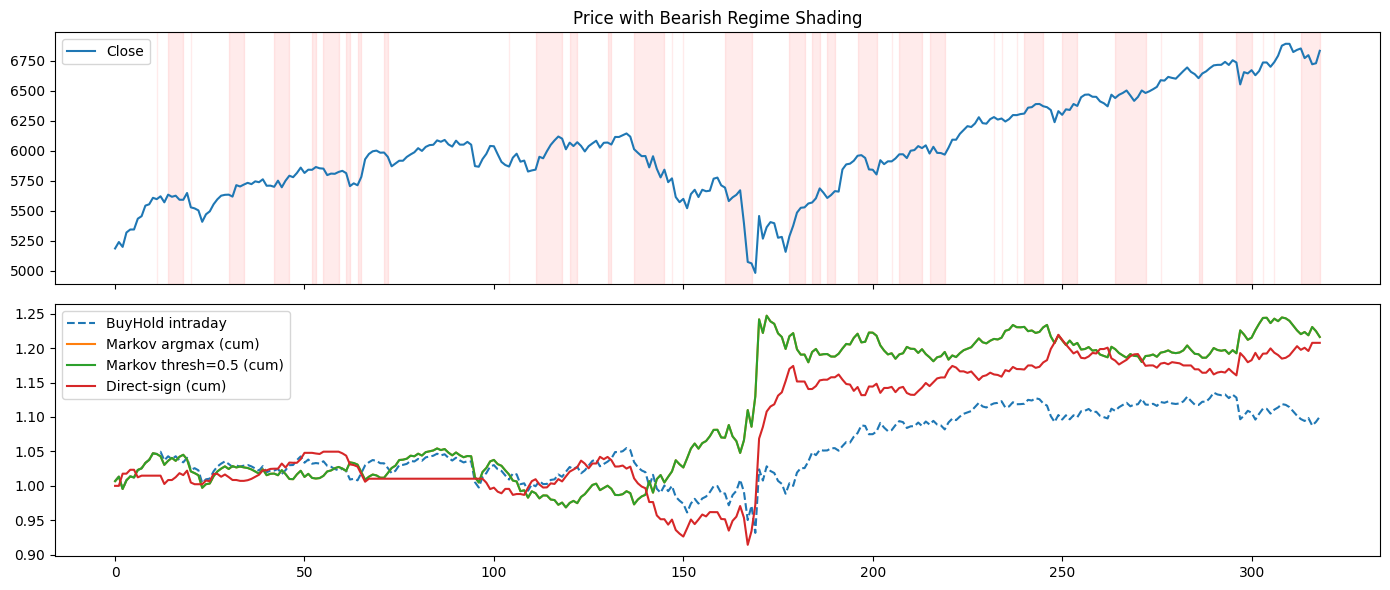

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Price with state shading
ax1.plot(df.index, df['Close'], label='Close', color='tab:blue')
bearish = (df['market_state'] == 'bearish')
# Shade contiguous bearish spans
spans = bearish.ne(bearish.shift()).cumsum()
for key, is_bear in spans.groupby(spans).apply(lambda s: bearish.loc[s.index[0]]).items():
    if is_bear:
        seg = df.index[spans == key]
        ax1.axvspan(seg[0], seg[-1], color='red', alpha=0.08)
ax1.legend()
ax1.set_title('Price with Bearish Regime Shading')

# Cumulative returns (as in your code)
ax2.plot(df.index, df['cum_buyhold'], label='BuyHold intraday', linestyle='--')
ax2.plot(df.index, df['cum_markov_argmax'], label='Markov argmax (cum)')
ax2.plot(df.index, df['cum_markov_thresh'], label=f'Markov thresh={THRESH} (cum)')
ax2.plot(df.index, df['cum_direct'], label='Direct-sign (cum)')
ax2.legend()
plt.tight_layout()
plt.show()


net_bps_signal summary:
count    319.000000
mean      -0.655172
std        4.164868
min      -19.000000
25%       -3.000000
50%        0.000000
75%        1.500000
max       11.000000
Name: net_bps_signal, dtype: float64

State counts (bullish/bearish):
market_state
bullish    187
bearish    132
Name: count, dtype: int64

TRAIN raw transition counts (rows = prev state):
market_state  bearish  bullish
market_state                  
bearish            77       29
bullish            30      118

TRAIN normalized transition probabilities:
market_state   bearish   bullish
market_state                    
bearish       0.726415  0.273585
bullish       0.202703  0.797297

OOS Performance (last 20%):
Buy-hold intraday: 0.08% | Sharpe: 0.08
Markov OOS argmax: 0.72% | trades: 64 | Sharpe: 0.35 | mean conf: 0.77
Markov OOS thresh=0.5: 0.72% | trades: 64 | Sharpe: 0.35 | mean conf (trades): 0.77
Direct-sign OOS: 1.03% | trades: 57 | Sharpe: 0.49


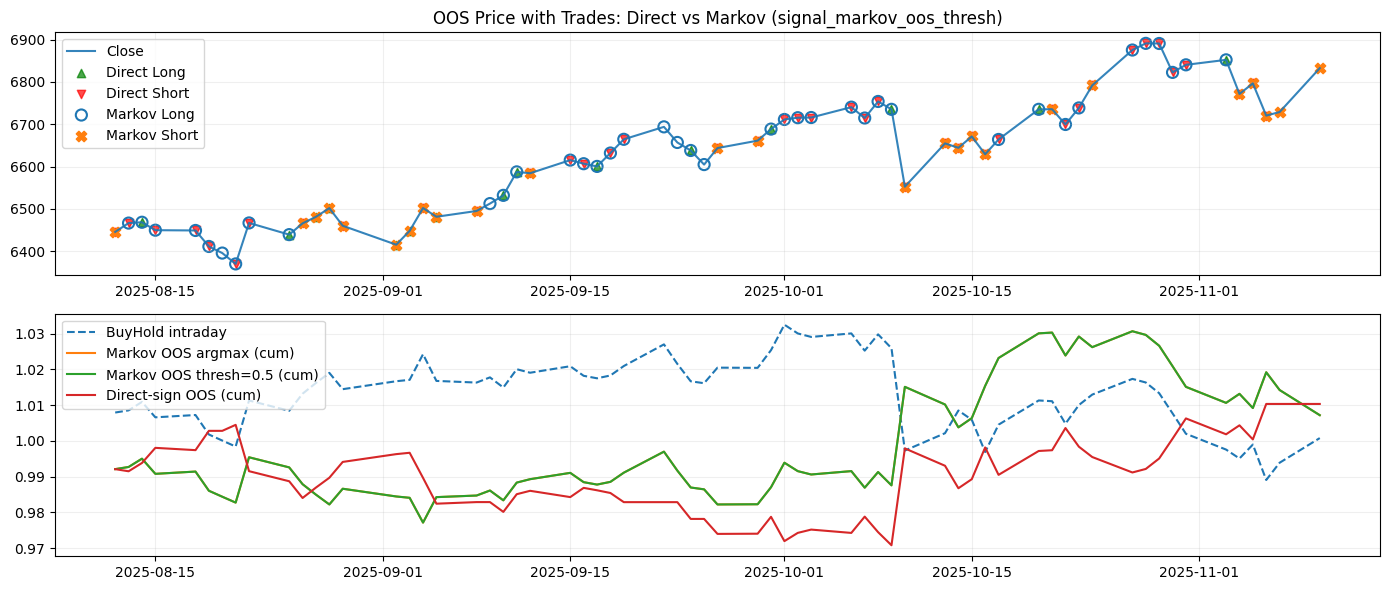


Saved OOS trades CSV: outputs\trades_oos.csv | rows: 185


In [66]:
# 80/20 chronological Markov holdout with plotting, Sharpe, and trades CSV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Make local copy (safe to re-run)
df = df.copy()

# Ensure we have a proper datetime index named 'Date'
if 'Date' in df.columns and not isinstance(df.index, pd.DatetimeIndex):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).set_index('Date').sort_index()
elif isinstance(df.index, pd.DatetimeIndex):
    df = df.sort_index()
else:
    raise ValueError("Data must have a Date column or DatetimeIndex.")

# Ensure market_state is binary: 'bullish' or 'bearish'
state_map = {
    'up': 'bullish',
    'down': 'bearish',
    'neutral': np.nan,
    'bullish': 'bullish',
    'bearish': 'bearish',
    'Bullish': 'bullish',
    'Bearish': 'bearish'
}
if 'market_state' not in df.columns:
    raise ValueError("market_state column missing")

df['market_state'] = df['market_state'].map(state_map).ffill().fillna('bullish')  # forward-fill + fallback

# Quick diagnostics of net_bps_signal and state distribution
if 'net_bps_signal' in df.columns:
    print('\nnet_bps_signal summary:')
    print(df['net_bps_signal'].describe())

print('\nState counts (bullish/bearish):')
print(df['market_state'].value_counts())

# Ensure Open/Close exist
if not {'Open','Close'}.issubset(df.columns):
    raise ValueError('Open/Close missing for intraday backtest')

# Intraday returns (Close / Open - 1)
df['intraday_ret'] = df['Close'] / df['Open'] - 1.0

# Direct-sign strategy (no training needed)
if 'net_bps_signal' in df.columns:
    df['signal_direct'] = np.sign(df['net_bps_signal']).fillna(0).astype(int)
else:
    # If no net_bps_signal, default to flat direct signal so code still runs
    df['signal_direct'] = 0

# Chronological 80/20 split
states = ['bearish', 'bullish']
sig_map = {'bullish': 1, 'bearish': -1}
THRESH = 0.5
PERIODS_PER_YEAR = 252

split = int(len(df) * 0.8)
train_idx = df.index[:split]
test_idx  = df.index[split:]

train = df.loc[train_idx]
test  = df.loc[test_idx]

# Fit transitions on TRAIN only
trans_counts_tr = (
    pd.crosstab(train['market_state'].shift(1), train['market_state'])
      .reindex(index=states, columns=states, fill_value=0)
      .astype(int)
)
row_sums_tr = trans_counts_tr.sum(axis=1)
trans_prob_tr = trans_counts_tr.div(row_sums_tr.replace(0, 1), axis=0)

# Fallback to uniform if a row is unseen in train
for s in states:
    if row_sums_tr.get(s, 0) == 0:
        trans_prob_tr.loc[s] = [0.5, 0.5]

print('\nTRAIN raw transition counts (rows = prev state):')
print(trans_counts_tr)
print('\nTRAIN normalized transition probabilities:')
print(trans_prob_tr)

# Predict OOS on TEST using TRAIN matrix
def predict_from_prev(prev):
    if pd.isna(prev):
        return 'bullish', 0.5
    row = trans_prob_tr.loc[prev]
    mx = float(row.max())
    return row.idxmax(), mx

prev_test = df['market_state'].shift(1).loc[test_idx]
preds = prev_test.apply(predict_from_prev)

df.loc[test_idx, 'pred_state_oos'] = preds.map(lambda x: x[0])
df.loc[test_idx, 'pred_conf_oos']  = preds.map(lambda x: x[1])

df.loc[test_idx, 'signal_markov_oos'] = df.loc[test_idx, 'pred_state_oos'].map(sig_map).fillna(0).astype(int)
df.loc[test_idx, 'signal_markov_oos_thresh'] = np.where(
    df.loc[test_idx, 'pred_conf_oos'] >= THRESH,
    df.loc[test_idx, 'signal_markov_oos'],
    0
).astype(int)

# Backtest helper on OOS slice
def backtest_oos(sig_series):
    r = sig_series.loc[test_idx] * df.loc[test_idx, 'intraday_ret']
    c = (1 + r.fillna(0)).cumprod()
    return r, c

ret_markov_oos,        cum_markov_oos        = backtest_oos(df['signal_markov_oos'])
ret_markov_oos_thresh, cum_markov_oos_thresh = backtest_oos(df['signal_markov_oos_thresh'])
ret_direct_oos,        cum_direct_oos        = backtest_oos(df['signal_direct'])
cum_buyhold_oos = (1 + df.loc[test_idx, 'intraday_ret'].fillna(0)).cumprod()

# Sharpe ratio (annualized, rf=0)
def sharpe_ratio(ret_series, periods_per_year=252, rf_annual=0.0):
    r = pd.Series(ret_series).dropna()
    if len(r) == 0 or r.std() == 0:
        return np.nan
    excess = r - (rf_annual / periods_per_year)
    return np.sqrt(periods_per_year) * excess.mean() / excess.std()

print('\nOOS Performance (last 20%):')
print(f"Buy-hold intraday: {(cum_buyhold_oos.iloc[-1]-1):.2%} | Sharpe: {sharpe_ratio(df.loc[test_idx, 'intraday_ret']):.2f}")
print(f"Markov OOS argmax: {(cum_markov_oos.iloc[-1]-1):.2%} | trades: {(df.loc[test_idx, 'signal_markov_oos']!=0).sum()} | Sharpe: {sharpe_ratio(ret_markov_oos):.2f} | mean conf: {df.loc[test_idx, 'pred_conf_oos'].mean():.2f}")
print(f"Markov OOS thresh={THRESH}: {(cum_markov_oos_thresh.iloc[-1]-1):.2%} | trades: {(df.loc[test_idx, 'signal_markov_oos_thresh']!=0).sum()} | Sharpe: {sharpe_ratio(ret_markov_oos_thresh):.2f} | mean conf (trades): {df.loc[test_idx, 'pred_conf_oos'][df.loc[test_idx, 'signal_markov_oos_thresh']!=0].mean():.2f}")
print(f"Direct-sign OOS: {(cum_direct_oos.iloc[-1]-1):.2%} | trades: {(df.loc[test_idx, 'signal_direct']!=0).sum()} | Sharpe: {sharpe_ratio(ret_direct_oos):.2f}")

# Plot: OOS price with Direct vs Markov trade markers, and OOS cumulative PnL
plt.figure(figsize=(14,6))

# Panel 1: Price with trade markers (Direct vs Markov, OOS only)
ax1 = plt.subplot(2,1,1)
oos = df.loc[test_idx]
ax1.plot(oos.index, oos['Close'], label='Close', color='tab:blue', linewidth=1.5, alpha=0.9)

# Direct markers
dir_long_idx  = oos.index[oos['signal_direct'] == 1]
dir_short_idx = oos.index[oos['signal_direct'] == -1]
ax1.scatter(dir_long_idx,  oos.loc[dir_long_idx,  'Close'], marker='^', color='green', s=36, label='Direct Long', alpha=0.7)
ax1.scatter(dir_short_idx, oos.loc[dir_short_idx, 'Close'], marker='v', color='red',   s=36, label='Direct Short', alpha=0.7)

# Markov markers (thresholded by default)
markov_col = 'signal_markov_oos_thresh'  # change to 'signal_markov_oos' to see argmax
mk_long_idx  = oos.index[oos[markov_col] == 1]
mk_short_idx = oos.index[oos[markov_col] == -1]
ax1.scatter(mk_long_idx,  oos.loc[mk_long_idx,  'Close'], marker='o', facecolors='none', edgecolors='tab:blue', s=64, linewidths=1.5, label='Markov Long')
ax1.scatter(mk_short_idx, oos.loc[mk_short_idx, 'Close'], marker='X', color='tab:orange', s=56, label='Markov Short')

ax1.set_title(f'OOS Price with Trades: Direct vs Markov ({markov_col})')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.2)

# Panel 2: OOS cumulative returns
ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(oos.index, cum_buyhold_oos,        label='BuyHold intraday', linestyle='--')
ax2.plot(oos.index, cum_markov_oos,         label='Markov OOS argmax (cum)')
ax2.plot(oos.index, cum_markov_oos_thresh,  label=f'Markov OOS thresh={THRESH} (cum)')
ax2.plot(oos.index, cum_direct_oos,         label='Direct-sign OOS (cum)')
ax2.legend()
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# ---- Export OOS trades CSV ----
def build_trade_df_oos(sig_col, strategy_name):
    mask = df.loc[test_idx, sig_col] != 0
    idx = df.loc[test_idx].index[mask]
    tmp = df.loc[idx, ['Open', 'Close', 'intraday_ret', sig_col, 'market_state']].copy()
    tmp.rename(columns={sig_col: 'signal'}, inplace=True)
    tmp['side'] = tmp['signal'].map({1: 'long', -1: 'short'})
    tmp['strategy'] = strategy_name
    tmp['ret'] = tmp['signal'] * tmp['intraday_ret']
    tmp['pred_conf'] = df.loc[idx, 'pred_conf_oos'] if 'markov' in strategy_name else np.nan
    tmp['entry_price'] = tmp['Open']   # consistent with intraday_ret = Close/Open - 1
    tmp['exit_price']  = tmp['Close']
    cols = ['strategy','side','signal','market_state','pred_conf','entry_price','exit_price','intraday_ret','ret']
    return tmp[cols]

trades_oos = pd.concat([
    build_trade_df_oos('signal_markov_oos',        'markov_oos_argmax'),
    build_trade_df_oos('signal_markov_oos_thresh', 'markov_oos_thresh'),
    build_trade_df_oos('signal_direct',            'direct_oos')
]).sort_index()

os.makedirs('outputs', exist_ok=True)
csv_path = os.path.join('outputs', 'trades_oos.csv')
trades_oos.to_csv(csv_path, index_label='Date')
print(f"\nSaved OOS trades CSV: {csv_path} | rows: {len(trades_oos)}")


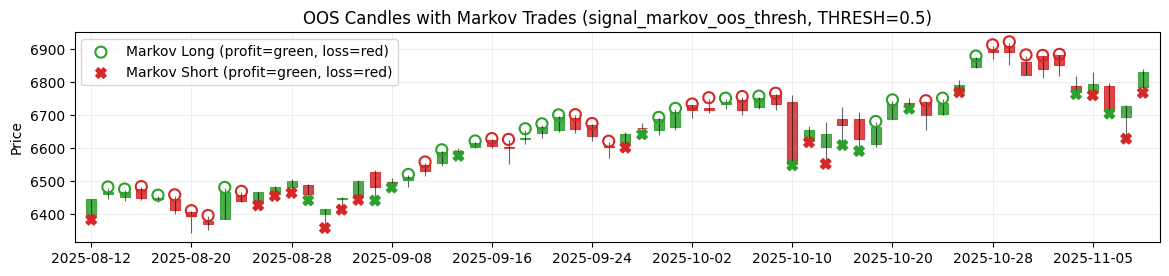

In [68]:
from matplotlib.patches import Rectangle

def plot_candles(ax, data, body_width=0.6, color_up='#2ca02c', color_down='#d62728'):
    x = np.arange(len(data))
    o = data['Open'].values
    c = data['Close'].values
    has_hl = {'High','Low'}.issubset(data.columns)
    if has_hl:
        h = data['High'].values
        l = data['Low'].values

    colors = np.where(c >= o, color_up, color_down)

    # Wicks
    if has_hl:
        for xi, hi, lo in zip(x, h, l):
            ax.vlines(xi, lo, hi, color='black', linewidth=0.8, alpha=0.6)

    # Bodies (Open/Close)
    prange = float(data['Close'].max() - data['Close'].min())
    min_body = prange * 0.002 if prange > 0 else 1e-6
    for xi, oi, ci, col in zip(x, o, c, colors):
        lower = min(oi, ci)
        height = max(abs(ci - oi), min_body)  # ensure visible doji
        rect = Rectangle((xi - body_width/2, lower), body_width, height,
                         facecolor=col, edgecolor=col, linewidth=0.8, alpha=0.85)
        ax.add_patch(rect)

    # X-axis as dates
    ax.set_xlim(-1, len(data))
    ticks = x[::max(1, len(x)//10)]
    ax.set_xticks(ticks)
    ax.set_xticklabels([pd.to_datetime(d).date() for d in data.index[ticks]])
    ax.set_ylabel('Price')
    ax.grid(alpha=0.2)
    return x

# ---- Candles + Markov only (OOS) ----
plt.figure(figsize=(14,6))

ax1 = plt.subplot(2,1,1)
oos = df.loc[test_idx].copy()
xpos = plot_candles(ax1, oos, body_width=0.6)

# Position map for markers
pos_map = {idx: i for i, idx in enumerate(oos.index)}

# Choose which Markov to show
markov_col = 'signal_markov_oos_thresh'  # or 'signal_markov_oos'

# Profit coloring for markers
pnl = oos[markov_col] * oos['intraday_ret']
mk_long = oos[oos[markov_col] == 1]
mk_short = oos[oos[markov_col] == -1]
long_colors = ['#2ca02c' if pnl.loc[i] > 0 else '#d62728' for i in mk_long.index]
short_colors = ['#2ca02c' if pnl.loc[i] > 0 else '#d62728' for i in mk_short.index]

# Y positions: above highs / below lows if available; else offset from Close
if {'High','Low'}.issubset(oos.columns):
    pad = (oos['High'] - oos['Low']).median() * 0.05
    y_long = oos.loc[mk_long.index, 'High'] + pad
    y_short = oos.loc[mk_short.index, 'Low'] - pad
else:
    pad = oos['Close'].median() * 0.003
    y_long = oos.loc[mk_long.index, 'Close'] * (1 + 0.003)
    y_short = oos.loc[mk_short.index, 'Close'] * (1 - 0.003)

# Plot markers (green = profitable, red = loss)
ax1.scatter([pos_map[i] for i in mk_long.index],  y_long,
            marker='o', facecolors='none', edgecolors=long_colors, s=64, linewidths=1.5,
            label='Markov Long (profit=green, loss=red)', zorder=3)
ax1.scatter([pos_map[i] for i in mk_short.index], y_short,
            marker='X', c=short_colors, s=56, label='Markov Short (profit=green, loss=red)', zorder=3)

ax1.set_title(f'OOS Candles with Markov Trades ({markov_col}, THRESH={THRESH})')
ax1.legend(loc='upper left')


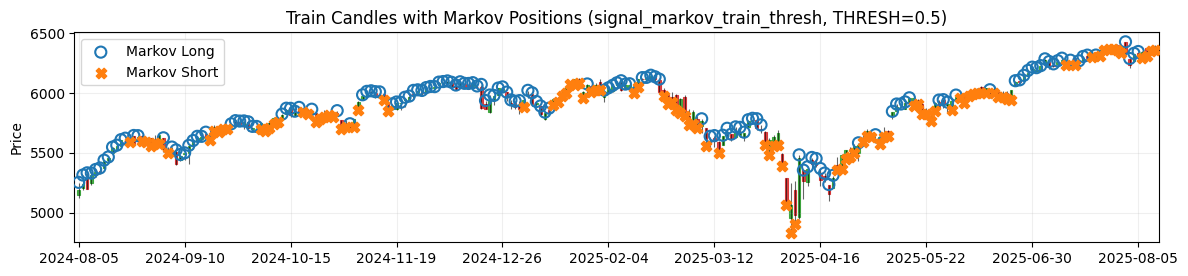

In [69]:
# ==== Train-set predictions/signals using train-fitted matrix ====
def predict_from_prev_train(prev):
    if pd.isna(prev):
        return 'bullish', 0.5
    row = trans_prob_tr.loc[prev]
    return row.idxmax(), float(row.max())

prev_train = df['market_state'].shift(1).loc[train_idx]
preds_tr = prev_train.apply(predict_from_prev_train)

df.loc[train_idx, 'pred_state_train'] = preds_tr.map(lambda x: x[0])
df.loc[train_idx, 'pred_conf_train']  = preds_tr.map(lambda x: x[1])

df.loc[train_idx, 'signal_markov_train'] = df.loc[train_idx, 'pred_state_train'].map(sig_map).fillna(0).astype(int)
df.loc[train_idx, 'signal_markov_train_thresh'] = np.where(
    df.loc[train_idx, 'pred_conf_train'] >= THRESH,
    df.loc[train_idx, 'signal_markov_train'],
    0
).astype(int)

# Train-set returns (optional for panel 2)
train = df.loc[train_idx]
ret_markov_train        = train['signal_markov_train']        * train['intraday_ret']
ret_markov_train_thresh = train['signal_markov_train_thresh'] * train['intraday_ret']
cum_buyhold_train       = (1 + train['intraday_ret'].fillna(0)).cumprod()
cum_markov_train        = (1 + ret_markov_train.fillna(0)).cumprod()
cum_markov_train_thr    = (1 + ret_markov_train_thresh.fillna(0)).cumprod()

# ==== Train-set candlesticks + Markov positions only ====
# Reuse plot_candles(ax, data, ...) defined earlier. If not defined, reinsert its definition.

plt.figure(figsize=(14,6))

ax1 = plt.subplot(2,1,1)
tr = df.loc[train_idx].copy()
xpos = plot_candles(ax1, tr, body_width=0.6)

# Position map for markers (dates -> x positions)
pos_map_tr = {idx: i for i, idx in enumerate(tr.index)}

# Choose which Markov train signal to show
markov_train_col = 'signal_markov_train_thresh'  # or 'signal_markov_train' for argmax

mk_long_tr  = tr.index[tr[markov_train_col] == 1]
mk_short_tr = tr.index[tr[markov_train_col] == -1]

# Y positions for markers (side only; outcome is in candle color)
if {'High','Low'}.issubset(tr.columns):
    pad = (tr['High'] - tr['Low']).median() * 0.05
    y_long  = tr.loc[mk_long_tr,  'High'] + pad
    y_short = tr.loc[mk_short_tr, 'Low']  - pad
else:
    pad = tr['Close'].median() * 0.003
    y_long  = tr.loc[mk_long_tr,  'Close'] * (1 + 0.003)
    y_short = tr.loc[mk_short_tr, 'Close'] * (1 - 0.003)

# Neutral markers: side only (no PnL coloring)
ax1.scatter([pos_map_tr[i] for i in mk_long_tr],  y_long,
            marker='o', facecolors='none', edgecolors='tab:blue', s=64, linewidths=1.5,
            label='Markov Long', zorder=3)
ax1.scatter([pos_map_tr[i] for i in mk_short_tr], y_short,
            marker='X', color='tab:orange', s=56, label='Markov Short', zorder=3)

ax1.set_title(f'Train Candles with Markov Positions ({markov_train_col}, THRESH={THRESH})')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.2)

